In [ ]:
import os
import numpy as np

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Setting folder

In [3]:
%cd /content/drive/"My Drive"/IRE
!pwd

/content/drive/My Drive/IRE
/content/drive/My Drive/IRE


In [ ]:
# from getpass import getpass
# user = getpass('GitHub user')
# password = getpass('GitHub password')
# os.environ['GITHUB_AUTH'] = user + ':' + password
# !git clone https://github.com/DeepakSinghRawat/fastai-bert-finetuning.git

GitHub user··········
GitHub password··········
Cloning into 'fastai-bert-finetuning'...
remote: Enumerating objects: 54, done.
remote: Total 54 (delta 0), reused 0 (delta 0), pack-reused 54
Unpacking objects: 100% (54/54), done.


In [ ]:
# !git config --global user.name Mehul1604
# !git config --global user.email mathurmehul3@gmail.com

In [ ]:
# %mv Bert_Paraphrase_Identification.ipynb ./fastai-bert-finetuning/

In [4]:
%cd fastai-bert-finetuning/

/content/drive/My Drive/IRE/fastai-bert-finetuning


In [5]:
!ls

 bert_fastai.py
 bert_helper.py
 bert_para_learner.pth
 Bert_Paraphrase_Identification.ipynb
 download_glue_data.py
'Finetuning Bert on MRPC Corpus using FastAI.ipynb'
 glue_data
 images
 Paraphrase_Identification_Training_MRPC.ipynb
 Paraphrase_Identification_Training_PAWS.ipynb
 __pycache__
 README.md
 requirements.txt
 Testing_Best_Para_Model.ipynb
 utils.py


## Finetuning

In [6]:
! pip install -r requirements.txt

     |████████████████████████████████| 233 kB 5.5 MB/s 
     |████████████████████████████████| 123 kB 42.4 MB/s 
     |████████████████████████████████| 131 kB 44.1 MB/s 
     |████████████████████████████████| 8.1 MB 46.4 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 127 kB 50.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [7]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import utils, bert_fastai, bert_helper

In [8]:

# Seed random generators so all model runs are reproducible

utils.seed_everything()

### Getting Data (PAWS)

In [9]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset("paws-x","en")

     |████████████████████████████████| 290 kB 5.3 MB/s 
     |████████████████████████████████| 1.3 MB 45.3 MB/s 
     |████████████████████████████████| 125 kB 43.2 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 243 kB 44.2 MB/s 
     |████████████████████████████████| 271 kB 45.5 MB/s 
     |████████████████████████████████| 160 kB 47.5 MB/s 


Downloading:   0%|          | 0.00/2.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/30.3M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset pawsx downloaded and prepared to /root/.cache/huggingface/datasets/pawsx/en/1.1.0/a5033b43902a02a4ba2ee469c1dd22af3e6a4a247ac47fa1af9835d0e734e2af. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
train_df = pd.DataFrame(data=dataset['train'][:])
validation_df = pd.DataFrame(data=dataset['validation'][:])
test_df = pd.DataFrame(data=dataset['test'][:])
display(train_df)
display(validation_df)
display(test_df)

,id,sentence1,sentence2,label
0,1,"In Paris , in October 1560 , he secretly met t...","In October 1560 , he secretly met with the Eng...",0
1,2,The NBA season of 1975 -- 76 was the 30th seas...,The 1975 -- 76 season of the National Basketba...,1
2,3,"There are also specific discussions , public p...","There are also public discussions , profile sp...",0
3,4,When comparable rates of flow can be maintaine...,The results are high when comparable flow rate...,1
4,5,It is the seat of Zerendi District in Akmola R...,It is the seat of the district of Zerendi in A...,1
...,...,...,...,...
49396,49397,""" Our school is of spiritual and spiritual , l...",""" Our School is of the Temporal and the Spirit...",0
49397,49398,She was in Cork on June 24 and arrived on 8 Ju...,"She was at Cork on 24 June , and arrived in th...",1
49398,49399,Cornelia Stuyvesant Vanderbilt ( George and Ed...,John John F. A. Cecil ( the only child of Geor...,0
49399,49400,The third season was premiered on 7 June 2010 ...,"The fourth season was premiered on June 7 , 20...",0


,id,sentence1,sentence2,label
0,4,From the merger of the Four Rivers Council and...,Shawnee Trails Council was formed from the mer...,1
1,6,Kathy and her husband Pete Beale ( Peter Dean ...,Kathy and her husband Peter Dean ( Pete Beale ...,1
2,7,Timora diarhoda is a species of moth of the No...,Diarhoda is a kind of moth of the Noctuidae fa...,1
3,9,Joe R. Campa Jr. is a former sailor of the Uni...,Joe R. Campa Jr. is a former U.S. Navy Matrose...,1
4,13,"Cook Pond , also known as the South Watuppa Po...","Cook Pond , also formerly known as Laurel Lake...",0
...,...,...,...,...
1995,7976,"Lee has played professionally in Italy , Russi...","He played professionally in Greece , Russia , ...",0
1996,7981,Round Island is currently uninhabited and is o...,Round Island is currently uninhabited and is a...,0
1997,7987,She is praised by Richard Gibson and the court...,She is praised by Richard Gibson and the court...,0
1998,7988,"The JoyKey has no moving parts , no corks that...","The JoyKey has no moving parts , no corks that...",0


,id,sentence1,sentence2,label
0,10,The exception was between late 2005 and 2009 w...,"The exception was between late 2005 and 2009 ,...",1
1,12,The Tabaci River is a tributary of the River L...,The Leurda River is a tributary of the River T...,0
2,20,He played with the A-level Kane County Cougars...,He played in 1993 with the A - Level Portland ...,0
3,26,"Winarsky is a member of the IEEE , Phi Beta Ka...","Winarsky is a member of ACM , the IEEE , the P...",1
4,27,In 1938 he became the government anthropologis...,In 1938 he became the Government Anthropologis...,0
...,...,...,...,...
1995,7984,Bas Basie Land is a studio album by Count Basi...,Land Basie Land is a studio album by Billy Bye...,0
1996,7992,Their mission is to guard various space outpos...,Their mission is to guard various outposts fro...,0
1997,7993,"On his mother , Elizabeth 's side were Sir Wil...",On his mother 's side were Elizabeth William M...,0
1998,7999,In 2014 the site launched iOS and Android appl...,In 2014 launched the site iOS and Android - ap...,1


In [11]:
label_col = "label"
text_cols = ["sentence1", "sentence2"]

In [12]:
print(f"Number of Training records={len(train_df)}")
print(f"Number of Test records={len(test_df)}")

Number of Training records=49401
Number of Test records=2000


In [13]:
def sample_sentences(label, n=5):
    ctr = 0
    for row in train_df.query(f'label=={label}').itertuples():
        print(f"1. {row[2]}\n2. {row[3]}")
        print("="*100)
        ctr += 1
        if n==ctr:
            break

In [14]:
# labelled as not paraphrases
sample_sentences(0)

1. In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Throckmorton , asking him for a passport to return to England through Scotland .
2. In October 1560 , he secretly met with the English ambassador , Nicolas Throckmorton , in Paris , and asked him for a passport to return to Scotland through England .
1. There are also specific discussions , public profile debates and project discussions .
2. There are also public discussions , profile specific discussions , and project discussions .
1. Bullion Express - concept is being introduced new store in Dallas , Texas in Preston Center opened .
2. 2011-DGSE Bullion Express concept is introduced , new store opened in Preston Center in Dallas , Texas
1. The Soviet Union maintained an embassy in Oslo and a consulate in Barentsburg , while Norway maintained a message in Moscow .
2. The Soviet Union maintained an embassy in Moscow and a consulate in Barentsburg , while Norway maintained a message in Oslo .
1. Vocabulary 

In [15]:
# labelled as paraphrases
sample_sentences(1)

1. The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .
2. The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .
1. When comparable rates of flow can be maintained , the results are high .
2. The results are high when comparable flow rates can be maintained .
1. It is the seat of Zerendi District in Akmola Region .
2. It is the seat of the district of Zerendi in Akmola region .
1. William Henry Henry Harman was born on 17 February 1828 in Waynesboro , Virginia , where his parents were Lewis and Sally ( Garber ) Harman .
2. William Henry Harman was born in Waynesboro , Virginia on February 17 , 1828 . His parents were Lewis and Sally ( Garber ) Harman .
1. With a discrete amount of probabilities Formula 1 with the condition formula 2 and Formula 3 any real number , the Tsallis is defined as entropy as
2. Given a discrete set of probabilities formula _ 1 with the condition formula _ 2 , and formula _ 3 any real 

### Training setup

In [16]:
# Configuration for the fast ai learner
config = utils.Config(
    bert_model_name="bert-base-uncased",
    num_labels=2, # 0 or 1
    max_lr=2e-5,
    epochs=4,
    batch_size=32,
    max_seq_len=128
)

In [17]:
# tokenizer which converts sentences and pads tokens (format how BERT wants)
fastai_tokenizer = bert_fastai.FastAITokenizer(model_name=config.bert_model_name, max_seq_len=config.max_seq_len)

100%|██████████| 231508/231508 [00:00<00:00, 1708164.99B/s]


In [18]:
# Creating a databunch object
databunch = TextDataBunch.from_df(".", train_df=train_df, valid_df=test_df,
                  tokenizer=fastai_tokenizer.bert_tokenizer(),
                  vocab=fastai_tokenizer.fastai_bert_vocab(),
                  include_bos=False,
                  include_eos=False,
                  text_cols=text_cols,
                  label_cols=label_col,
                  bs=config.batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

/usr/local/lib/python3.7/dist-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [19]:
# Show wordpiece tokenized data

for i in range(5): 
    print(f"Original==> {train_df.loc[i][text_cols[0]]},{train_df.loc[i][text_cols[1]]}\n\nTokenized==>. {databunch.x[i]}")
    print("="*100)

Original==> In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Throckmorton , asking him for a passport to return to England through Scotland .,In October 1560 , he secretly met with the English ambassador , Nicolas Throckmorton , in Paris , and asked him for a passport to return to Scotland through England .

Tokenized==>. [CLS] in paris , in october 1560 , he secretly met the english ambassador , nicolas th ##rock ##mo ##rton , asking him for a passport to return to england through scotland . in october 1560 , he secretly met with the english ambassador , nicolas th ##rock ##mo ##rton , in paris , and asked him for a passport to return to scotland through england . [SEP]
Original==> The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .,The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .

Tokenized==>. [CLS] the nba season of 1975 - - 76 was the 30th season of the national basketba

### Model

In [ ]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification


bert_model = BertForSequenceClassification.from_pretrained(
    config.bert_model_name, num_labels=config.num_labels)

# Initialising the Learner object
learner = bert_fastai.BertLearner(databunch,
                                  bert_model,
                                  metrics=[accuracy])



learner.callbacks.append(ShowGraph(learner))

100%|██████████| 407873900/407873900 [00:12<00:00, 33948544.98B/s]


**Scores before training**<br>
*Accuracy = 53.6% , F1 score = 9.7%*

In [ ]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.5360000133514404, f1_score=0.09727626459143968


**Training**

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.522695,0.447943,0.788000,18:21
0,0.522695,0.447943,0.788000,18:21
1,0.230631,0.231232,0.918500,19:25
1,0.230631,0.231232,0.918500,19:25
2,0.150596,0.251808,0.931000,19:07
2,0.150596,0.251808,0.931000,19:07
3,0.112169,0.272477,0.931000,17:47
3,0.112169,0.272477,0.931000,17:47


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


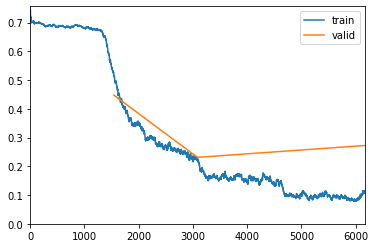

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

**Scores after training**<br>
*Accuracy = 93.1% , F1 score = 92.65%*

In [ ]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.9309999942779541, f1_score=0.9265957446808509


In [ ]:
# saving the model
learner.save('bert_para_learner', with_opt=True)

In [ ]:
torch.save(bert_model,'model_file') #maybe unnecessary, learner probably has it already. saved nonetheless.